<a href="https://colab.research.google.com/github/sammyculotta/PHY122-Lab/blob/main/phy122_lab5_SC_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHY122 Lab 5: Pendulum

Michael Culotta

04/28/25

#   <font color='Green'> **Setup** </font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

π = np.pi

In [3]:
import scipy
from scipy.special import ellipj, ellipk

def get_radian(deg):
    return π * deg / 180

def get_degree(rad):
    return 180 * rad / π

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def get_Qdot(Q, L, IIi):

    ω = np.append([0.],  IIi @ L)

    B = 0.5*np.asarray([[ Q[0], -Q[1], -Q[2], -Q[3] ],
                        [ Q[1],  Q[0], -Q[3],  Q[2] ],
                        [ Q[2],  Q[3],  Q[0], -Q[1] ],
                        [ Q[3], -Q[2],  Q[1],  Q[0] ]])

    return B @ ω

def get_EulerAngles(Q):

    φ = np.arctan2( 2*(Q[0]*Q[1] + Q[2]*Q[3]) , 1 - 2*(Q[1]**2 + Q[2]**2) )
    θ = np.arcsin(  2*(Q[0]*Q[2] + Q[3]*Q[1] ) ) ## np.tan() ?? np.arcsin
    ψ = np.arctan2( 2*(Q[0]*Q[3] + Q[1]*Q[2]) , 1 - 2*(Q[2]**2 + Q[3]**2) )

    return np.asarray([φ, θ, ψ])

def get_Qauternions(Θ):

    φ = Θ[0]
    θ = Θ[1]
    ψ = Θ[2]

    ## Q[0] has all cosines, then for each component replace one sine, then add/subtract the flip of this
    Q = np.asarray([ np.cos(φ/2)*np.cos(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.sin(φ/2)*np.cos(θ/2)*np.cos(ψ/2) - np.cos(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.sin(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.cos(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.cos(θ/2)*np.sin(ψ/2) - np.sin(φ/2)*np.sin(θ/2)*np.cos(ψ/2)])

    return Q

def sn(arg, k):
    sn = scipy.special.ellipj( arg , k)[0]
    return np.nan_to_num(sn, nan=1.)


def EllipticK(k):
    return scipy.special.ellipk(k)


class PhysicalPendulum(object):
    # 6/30/21
    ''' Pendulum Initialization '''
    def __init__(self):

        ### Constants
        self.g    = 9.81 # meters/second-squared : gravitational acceleration
        self.L    = 1.00 # meters : moment-of-inertia length
        #self.R    = 1.00 # meters : rotation-arm length
        self.drag = 0.00 # kg/seconds : Stokes drag / viscous damping coefficient
        self.mass = 1.00 # kg

        ### calculated constants
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        ### calculations
        self.angle0      = None
        self.dynamicsrun = None
        self.dynamicst   = None
        self.freqprofile = None
        self.freq        = None

    def dynamics(self, Θ_0, dt=0.01, T=100, ω_0=[0.,0.,0.], error=0.25, dimension=1):

        ### calculated constants
        self.Θ    = Θ_0
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        self.angle0 = Θ_0
        Θ_0    = np.asarray([Θ_0, 0.0, 0.0])
        Θ_0    = get_radian(Θ_0)
        L      = self.II @ ω_0
        time   = np.arange(0, T, dt)
        Q      = get_Qauternions(Θ_0)
        θ_data = np.zeros( (time.shape[0], 3) )

        for i in range(len(time)):

            θ_data[i] = get_degree( get_EulerAngles(Q) + (Θ_0[0]/180) * error*(np.random.rand(3) - 0.5) )

            τ = self.II @ ( - self.C2 @ np.sin(get_EulerAngles(Q)) - self.C1 @ ( self.IIi @ L ) ) ## leave τ & L in Euler angles!

            L_t = L + dt * τ / 2
            L   = L + dt * τ

            Qdot_t = get_Qdot(Q, L_t, self.IIi)
            Qdt = Q + dt/2 * Qdot_t

            Qdot_tdt = get_Qdot(Qdt, L, self.IIi)
            Q = Q + dt * Qdot_tdt

        self.dynamicst   = time
        self.dynamicsrun = (θ_data[:,:dimension].T)[0]

        return self.dynamicst , self.dynamicsrun

    def frequency(self):
        self.freq   = get_ω(self.dynamicst)
        self.freqprofile = np.abs(2.0/len(self.dynamicst) * (np.fft.fft( self.dynamicsrun, axis=0 ))[:len(self.dynamicst)//2])
        self.getmax = self.freq[np.argmax(self.freqprofile)]
        return self.freq / (2 * np.pi), self.freqprofile

    def exactdynamics(self):
        t = self.dynamicst

        k  = np.sin( get_radian(self.angle0)/2 )**2
        K  = scipy.special.ellipk(k)
        Θt  = self.angle0 * sn(self.ω0 * t + K , k)

        return Θt

#   <font color='Red'> **Getting Started** </font>

####   <font color='Red'> To get started, let's define a pendulum object </font>

In [7]:
Experiment = PhysicalPendulum()
Experiment.L = 1 ## m
Experiment.mass = 10 ## kg
Experiment.g = 9.81 ## m/s/s

####   <font color='Red'> Next, let's change the objects: mass, L (length), gravity. </font>

In [8]:
Experiment.L = 2.14 ## m
Experiment.mass = 12 ## kg
print(Experiment.L)

2.14


####   <font color='Red'> Next, let's run the dynamics with an ideal release angle of your choice (in degrees). </font>

In [12]:
t, Θ_t = Experiment.dynamics(25, dt=0.1, T = 20)

####   <font color='Red'> Next, let's plot our dynamics results. </font>

Text(0, 0.5, 'Angle (Degrees)')

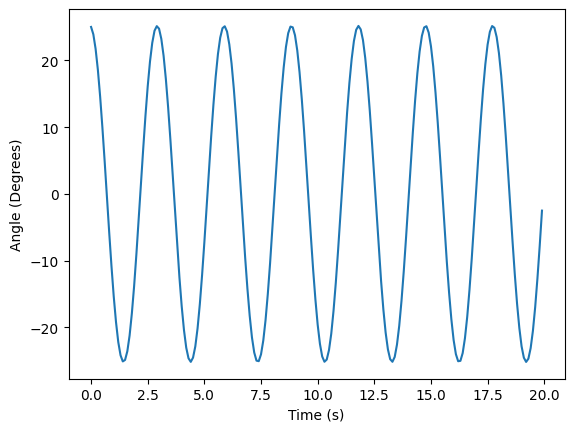

In [15]:
plt.plot(t,Θ_t)
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")

The above graph shows an angle oscillating between 25 and -25 degrees. The graph oscillates because of conservation of energy. At the highest point the pendulum has a maximum potential energy due to gravity and zero kinetic energy. As the pendulum begins to fall, the potential energy due to gravity will convert to kinetic energy as it speeds up. At the lowest point(theta=0) it has max kinetic energy with minimum potential energy. As the pendulum begins to swing back up to the other side these physics reverse with kinetic energy decreasing and potential energy increasing up to the max point of the swing. Energy is conserved through this process since we do not assume any other outside forces, so this back-and-forth motion will continue indefinitely.

###   <font color='Red'> Determine-and-Print the Period & the frequency of the plot above, using only the graph (and data above): </font>

In [27]:
period= 2.6 ## s
frequency = 1/period ## hz

print(period)
print(frequency)

2.6
0.3846153846153846


###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

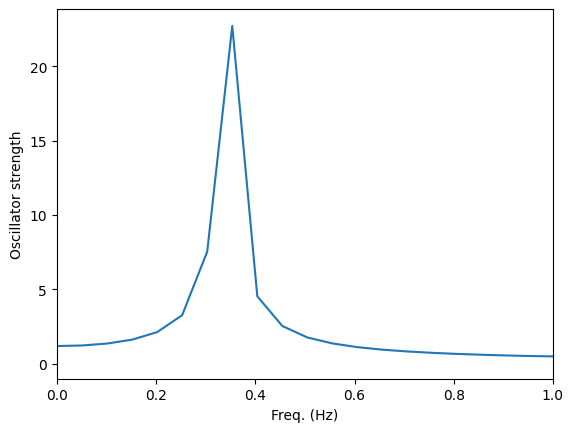

In [64]:
f, s = Experiment.frequency()

plt.plot(f,s)
plt.xlim([0,1])
plt.xlabel("Freq. (Hz)")
plt.ylabel("Oscillator strength")
plt.show()

The above graph shows us that the frequency spectrum (1/period) has a maximum frequency value at ~.38 Hz. In other words, the pendulum completes about .38 full swings every second or 1 full swing every 2.63 seconds.

###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

In [36]:
S_peak = np.argmax(s)
print(S_peak)

7


#   <font color='Red'> **Mass Experiment** </font>

### <font color='Green'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [37]:
Masses = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Masses))

for i in range(len(Masses)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 1 ## m
    MassExperiment.mass = Masses[i] ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Next let's plot our results: </font>

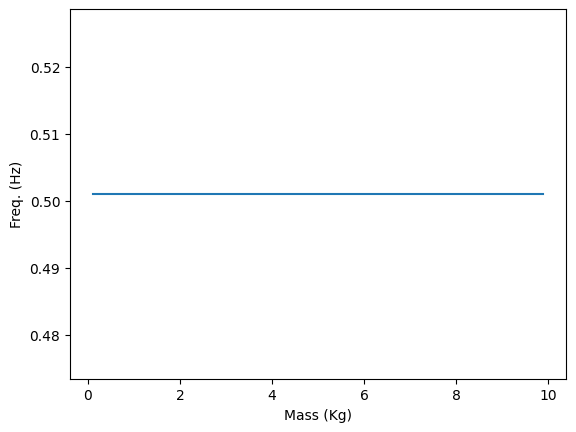

In [41]:
plt.plot(Masses, freqs)
plt.xlabel("Mass (Kg)")
plt.ylabel("Freq. (Hz)")
plt.show()

The above graph shows us mass (g) plotted against frequency (Hz). We can see that for each mass that is tested in the experiment, the frequency is constant. This tells us that frequency is independent of the mass of the pendulum.  The period T of a simple pendulum is T= 2πsqrt(g/L). So, it follows that as the mass changes the period will not be affected.

#   <font color='Red'> **Length Experiment** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [76]:
Length = np.arange(0.1, 10, 0.1) ## m
freqs  = np.empty(len(Length))

for i in range(len(Length)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = Length[i] ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

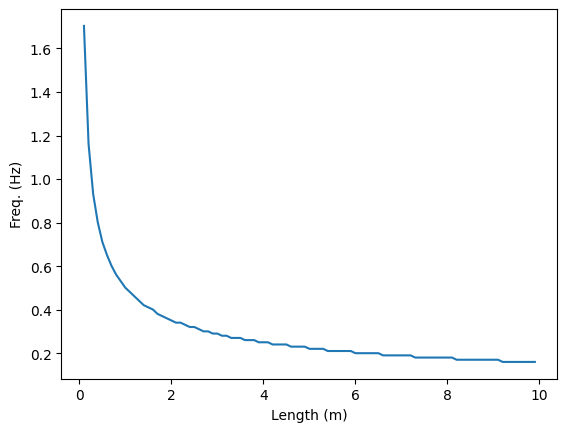

In [77]:
plt.plot(Length, freqs)
plt.xlabel("Length (m)")
plt.ylabel("Freq. (Hz)")
plt.show()

The above graph shows the relationship between the length of a pendulum and the frequency. The frequency of a pendulum's swing increases as its length decreases and decreases as its length increases.  Observing the formula T= 2πsqrt(g/L), it follows that the length will affect the frequency and since we divide by the length the relationship is inversely proportional. Upon close observation, we can see that as the length grows large, there are ripples in the graph. This is due to our time constraint of 100 seconds coupled with long periods. If we were to increase the total experiment time, or even reduce the time step, dt, we would see a smoothing out of the graph.

###   <font color='Red'> Let's plot our results in a linearized form: </font>

Length: 9.9 m, Frequency: 0.16032064128256512 Hz


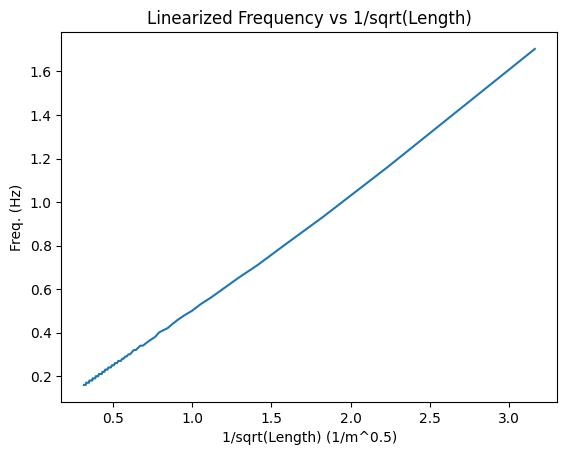

In [73]:
Linearized_variable = 1/np.sqrt(Length)

print(f"Length: {Length[i]} m, Frequency: {f[np.argmax(S)]} Hz")

plt.plot(Linearized_variable, freqs)
plt.xlabel("1/sqrt(Length) (1/m^0.5)")
plt.ylabel("Freq. (Hz)")
plt.title("Linearized Frequency vs 1/sqrt(Length)")
plt.show()

The above graph shows the linearized relationship between length and frequency. We see that frequency, f∝ 1/sqrt(L). I was expecting to see a negative slope, but we see a positive slope here. I was unable to figure out why we see a proportional and not the expected inverse relationship.

#   <font color='Red'> **Gravitational Acceleration** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [55]:
Grav = np.arange(0.1, 10, 0.1) ## m/s/s
freqs  = np.empty(len(Grav))

for i in range(len(Length)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 2.0 ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = Grav[i] ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

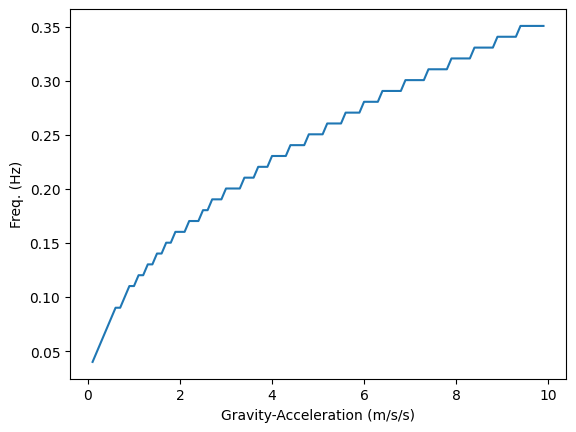

In [56]:
plt.plot(Grav, freqs)
plt.xlabel("Gravity-Acceleration (m/s/s)")
plt.ylabel("Freq. (Hz)")
plt.show()

The above graph shows how gravity and frequency are related for pendulum motion. The relationship is proportional, meaning the smaller the acceleration due to gravity, the smaller the frequency and the larger the acceleration due to gravity the larger the frequency. This means that on a planet, such as mars, which has a weaker gravitational force, we can expect the pendulum to have a smaller frequency (assuming the exact same length and mass pendulum). Again, we see that there are small wavelike fluctuations in the graph like when we analyzed the length variable. The reason for this is likely the same as we have a finite experiment time and a relatively moderate time step of .1s.

###   <font color='Red'> Let's plot our results in linearized form: </font>

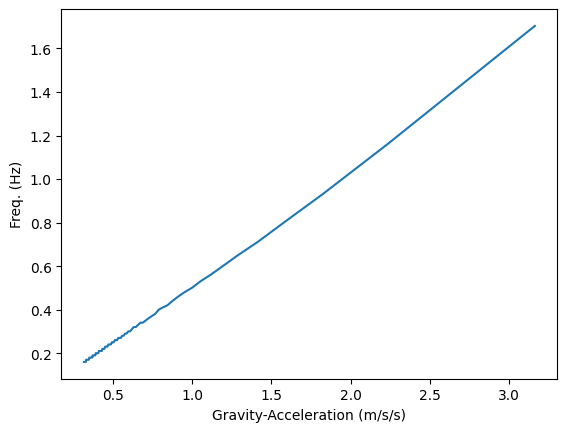

In [79]:
Lin_grav= 1/np.sqrt(Grav)

plt.plot(Lin_grav, freqs )
plt.xlabel("Gravity-Acceleration (m/s/s)")
plt.ylabel("Freq. (Hz)")
plt.show()

The above graph is the linearization of the previous gravity vs. frequency graph. We see proportional relationship with positive slope as expected. This means that the smaller the force of gravity the smaller the frequency and the larger the force due to gravity the larger the frequency. Going back to our formula for pendulum period,          T= 2πsqrt(g/L) it follows that the relationship of gravity to frequency is proportional.

#   <font color='Red'> **Release Angle (small)** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [88]:
Angle = np.arange(0.1, 360, 0.1) ## degrees
freqs  = np.empty(len(Angle))

for i in range(len(Angle)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 2.0 ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(Angle[i], dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

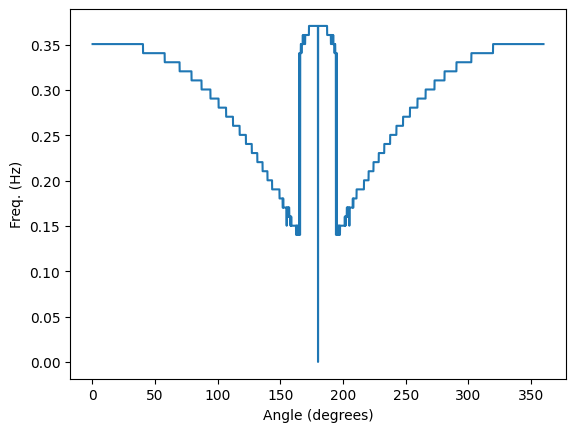

In [89]:
plt.plot(Angle, freqs)
plt.xlabel("Angle (degrees)")
plt.ylabel("Freq. (Hz)")
plt.show()

In the above graph we plot the angle (in degrees) vs the frequency of the pendulum. We see that as the angle increases, the frequency decreases up to a point. Which intuitively makes sense. Then once the angle exceeds 160 degrees the period jumps back to a similar period at a very small angle. This is trickier. I would expect the frequency to continue to decrease up to 180 degrees, at which point frequency would repeat itself in the opposite direction. If we think about a pendulum and starting the pendulum past 180 degrees, take 185 degrees for example, it would be the same thing as starting the pendulum from 175 degrees on the other side of the apex.

#   <font color='Red'> **Conclusion** </font>

In this lab we study the physics of a pendulum. We see that pendulums oscillate because of conservation of energy. We know that the period, T, of a simple pendulum is T= 2πsqrt(g/L). This gives us a foundation to start experimenting with each variable. First, we see that the mass has no effect on pendulum dynamics. However, both the length and gravity affect the period. Length is inversely proportional to the period and gravity is proportional to the period. We see in the final experiment that the angle will also affect the frequency at which the pendulum swings. The larger the angle at which the pendulum starts the longer the period, and the smaller the frequency. The true formula for pendulum motion is θ¨(t)+g/Lsin(θ(t))=0 however when we are measuring smaller angle’s we approximate sin(θ) ≈ θ. If you expand sin(θ) as a Taylor series the higher order terms can be neglected. At θ= 0 this is the resting point, and the pendulum will remain motionless. At θ=180 the pendulum points straight up. It is in unstable equilibrium and will fall with a tiny disturbance.